# ASTR 596: FDS Homework 5: Hunting for Exoplanets (Due April 1 at Noon)


### The Kepler satellite has discovered many multi-planet systems. You can download artwork for some of them even at the [Exoplanet Travel Bureau](https://exoplanets.nasa.gov/alien-worlds/exoplanet-travel-bureau/)

<img src="Kepler-186f_small.jpg" width="500">


### But is there a system like our own Solar system with 8 planets (sorry Pluto)? In fact, there may be at least one - [Kepler 90](https://www.nytimes.com/2017/12/14/science/eight-planets-star-system.html). This along with most other Kepler planets, were not discovered through radial velocity measurements like our example in class (i.e. that nice parameteric model doesn't apply), but were rather discovered through transits - dips in the light of the star as the planet moves around it.


<img src="Transiting-Exoplanet-Light-Curve.gif">

### You get to find 3 exoplanets in the Kepler-90 system with the techniques in class. 


### To get and analyze the Kepler data, you'll need the `lightkurve` package

> `python -m pip install lightkurve --upgrade`

### I've included some code to get the light curve, clean it and remove the NaNs, and some outliers (you can judge the wisdom of strong outlier removal when you are hunting for planets), and bin the light curve a little bit in time.


<hr>

#### Hints:


* `lightkurve` has a bunch of useful [tutorials](https://docs.lightkurve.org/index.html), in particular [this one](https://docs.lightkurve.org/tutorials/3-science-examples/periodograms-creating-periodograms.html)

* once you get to a periodogram with `lightkurve`, `find_peaks` in `scipy` can help identify the exoplanet peaks

* You might find it easier to remove the signal of each planet as you find it and work with the residual light curve to find the next. This isn't strictly necessary if you do the previous steps well, but can be helpful. The tutorials page has a demo.

* [The Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/index.html) might be of help

<hr>

# Happy (planet) hunting!

In [1]:
%matplotlib notebook
%pylab
import numpy as np
import astropy.table as at
import astropy.units as u
import matplotlib.pyplot as plt
import lightkurve as lk
from scipy.signal import find_peaks, find_peaks_cwt

Using matplotlib backend: nbAgg
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Users/yujiewan/miniconda3/envs/fds/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
### RUN THIS
lcfs = lk.search_lightcurve('Kepler-90', mission='Kepler').download_all()

In [3]:
### RUN THIS
def squelch_rednoise(lc):
    corrected_lc = lc.remove_outliers(sigma_upper=10, sigma_lower=10).normalize().flatten(window_length=901)
    return corrected_lc

<IPython.core.display.Javascript object>


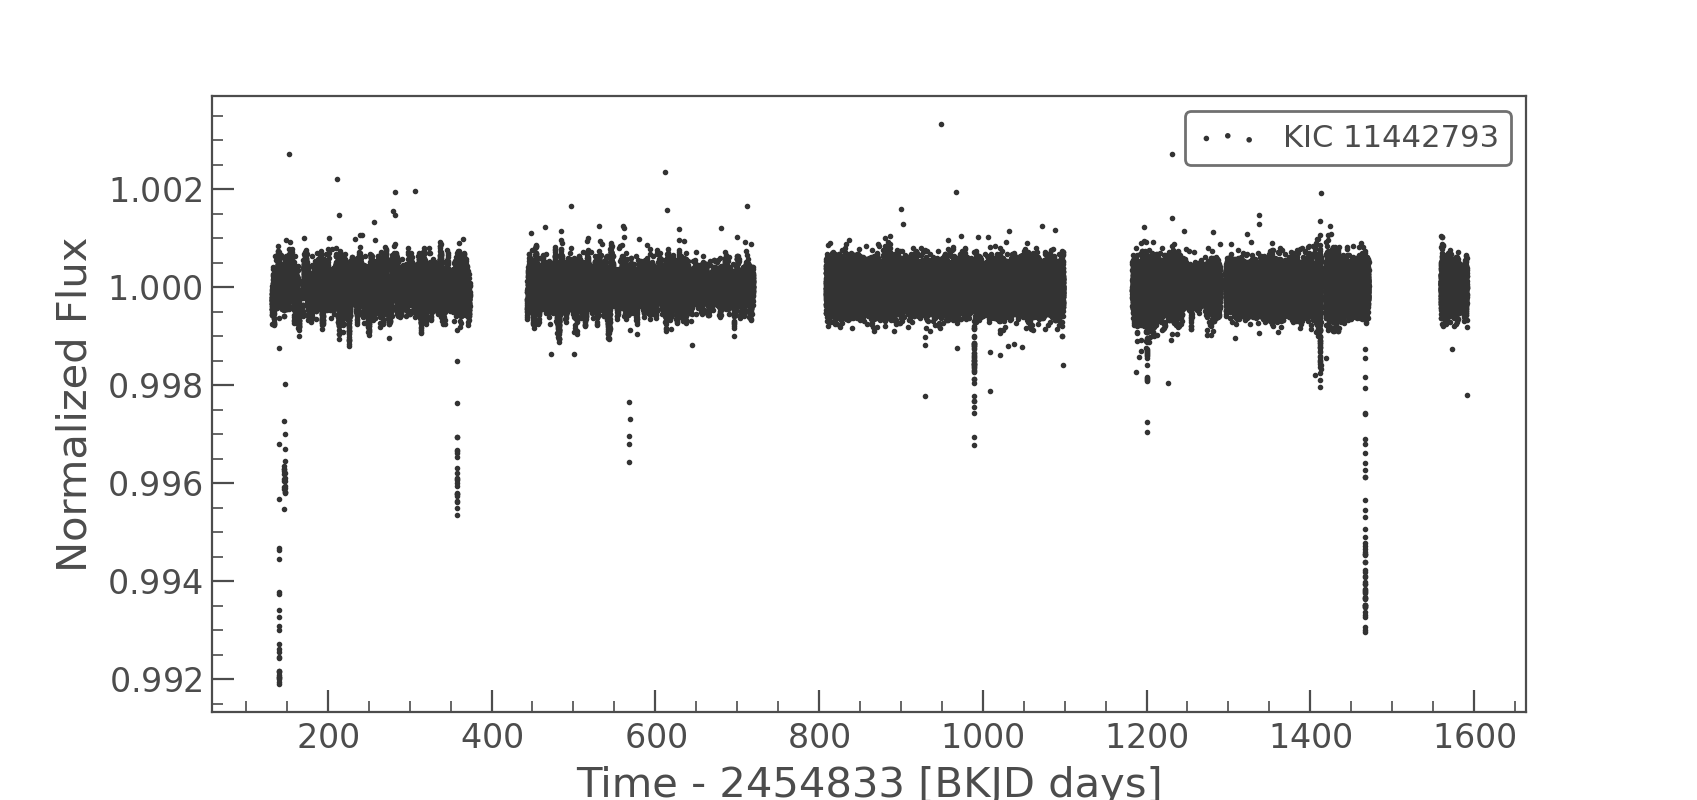

In [4]:
### RUN THIS - it will take a while.
stitched_lc = lcfs.stitch(corrector_func=squelch_rednoise)
clc = stitched_lc.remove_nans().bin(time_bin_size=15*u.min)
clc.scatter();

# This is the data we'll deal with

# Q1. First, calculate the periodogram using lightkurve. Use the `bls` method. Look for planets between 50 and 500 day periods with a grid spacing of 0.01d - this is coarse. Use `scipy.signal.find_peaks` to identify peaks in the periodogram. Remember to exclude any peaks arising from the Earth's revolution. Plot the periodogram and highlight the peak locations. (25 pts)


In [3]:
# create the periodogram
pg = clc.to_periodogram(method='bls',
                      minimum_period = 50,
                      maximum_period = 500,
                      period = np.linspace(50,500,45000))

In [4]:
#identify the peaks
peaks, _ = find_peaks(pg.power,distance = 500)

<IPython.core.display.Javascript object>


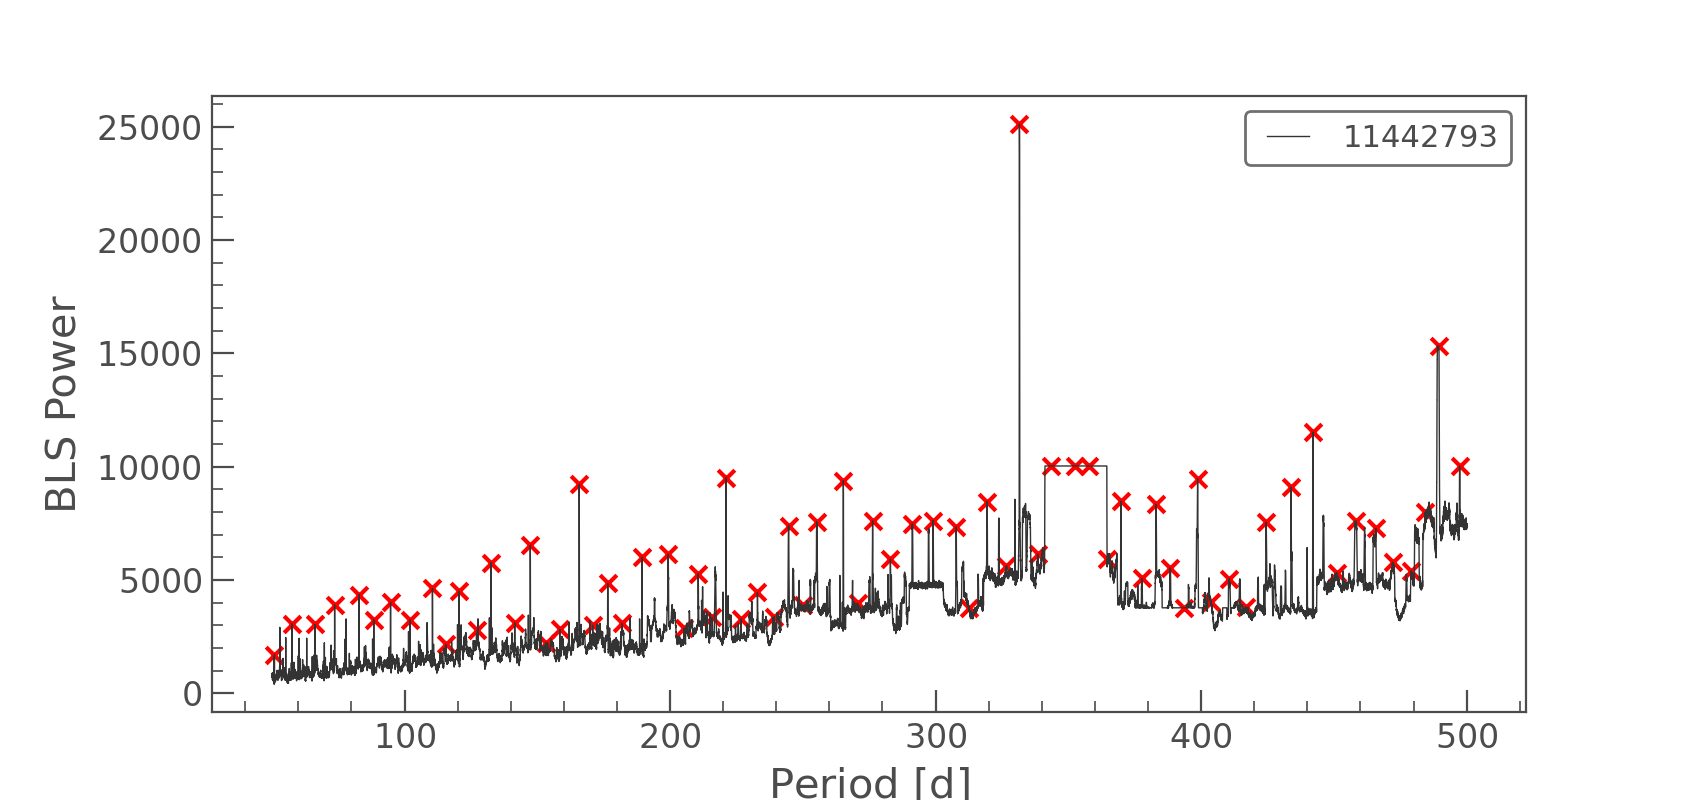

In [5]:
#plot the periodogram and the peak locations
pg.plot()
plt.scatter(pg.period[peaks],pg.power[peaks],marker = 'x',color = 'red')

# Q2. a. The periodogram function from lightkurve can also get a transit time and peak power using `periodogram.transit_time` and `periodogram.power` - you'll want both. Get a sorted list of candidate periods, and print it sorted by peak power. (10 pts)

In [6]:
power_sorted_index = np.argsort(pg.power[peaks])
for i in range(len(power_sorted_index)):
    print('period is:'+ str(pg.period[peaks][power_sorted_index[i]])+ '       power is:'+ str(pg.power[peaks][power_sorted_index[i]]))

period is:51.01002244494322 d       power is:1702.2426135671406
period is:115.56145692126492 d       power is:2159.4188222343623
period is:153.20229338429743 d       power is:2241.5210893921185
period is:127.48172181604038 d       power is:2795.225942021136
period is:158.4624102757839 d       power is:2827.3831377124516
period is:205.30345118780417 d       power is:2875.4021401792324
period is:170.85268561523588 d       power is:3001.658494455437
period is:66.32036267472611 d       power is:3044.917034483657
period is:57.67017044823218 d       power is:3078.7285013105698
period is:181.81292917620394 d       power is:3090.1129968438986
period is:141.5020333785195 d       power is:3111.9227370024487
period is:88.42085379675103 d       power is:3248.814149201834
period is:102.02115602568946 d       power is:3252.590664185515
period is:226.68392630947355 d       power is:3283.6827665271994
period is:215.87368608191292 d       power is:3357.553101986237
period is:239.26420587124161 d       

# Q2. b. Next sort the list of periods from longest to shorted. Check if each period has a period in your list that is either 1/2 or 1/3 the same value. If it is, exclude it. If not keep it. Select the four periods with the highest power between 0 to 100d, 100d and 200d, 200d and 300d and 300d and 400d. (15 pts)

In [8]:
from astropy.table import QTable, Table, Column
t = Table()
t['power'] = pg.power[peaks]
t['period'] = pg.period[peaks]

In [9]:
remove_row = []
for i in range(len(peaks)):
    if len(np.where((t['period']<3*t['period'][i]+0.25)&(t['period']>3*t['period'][i]-0.25))[0]) != 0:
        remove_row.append(i)
        continue
    elif len(np.where((t['period']<2*t['period'][i]+0.25)&(t['period']>2*t['period'][i]-0.25))[0]) != 0:
        remove_row.append(i)
        continue

t.remove_rows(remove_row)

In [10]:
#0-100

print ('No period between 0 to 100d')

No period between 0 to 100d


In [11]:
t_100_200 = t[(t['period']<200)&(t['period']>100)]
t_100_200.sort('power',reverse = True)
print('Periods between 100 to 200d with descending power')
t_100_200

Periods between 100 to 200d with descending power


power,period
,d
float64,float64
6013.071133192302,189.47309940220896
4857.31985168367,176.52281161803597
4506.006540171353,120.58156847929953
3252.590664185515,102.02115602568946
3090.1129968438986,181.81292917620394
3001.658494455437,170.85268561523588
2827.3831377124516,158.4624102757839
2795.225942021136,127.48172181604038


In [12]:
t_200_300 = t[(t['period']<300)&(t['period']>200)]
t_200_300.sort('power',reverse = True)
print('Periods between 200 to 300d with descending power')
t_200_300

Periods between 200 to 300d with descending power


power,period
,d
float64,float64
9390.942096955367,265.254783439632
7626.163400280696,299.0755350118892
7608.4652440019645,276.2850285561901
7571.955717985474,255.23456076801708
7475.6195918967815,291.1753594524323
5921.755035179831,283.0051778928421
5275.468093830456,210.59356874597214
3975.148947915446,270.65490344229875


In [13]:
t_300_400 = t[(t['period']<400)&(t['period']>300)]
t_300_400.sort('power',reverse = True)
print('Periods between 300 to 400d with descending power')
t_300_400

Periods between 300 to 400d with descending power


power,period
,d
float64,float64
25125.347543181404,331.5762572501611
10032.991481030338,357.69683770750464
10032.991481030338,352.4567212604725
10032.991481030338,343.52652281161807
9466.358608105815,398.6777483944088
8471.832527529315,369.7571057134603
...,...
5932.7919408764465,364.67699282206274


# Q3. Select each peak period from the coarse grid in Q2.b. and then use lightkurve algorithm to refine the period within +/- 5 days, and get the best period. (25 pts)

In [26]:
#finding the best period for 189d
pg_189 = clc.to_periodogram(method='bls',
                      minimum_period = 184,
                      maximum_period = 194)

In [28]:
peaks_189, _ = find_peaks(pg_189.power)

In [40]:
period1 = pg_189.period[np.where(pg_189.power == max(pg_189.power[peaks_189]))[0][0]]
transit_time1 = pg_189.transit_time[np.where(pg_189.power == max(pg_189.power[peaks_189]))[0][0]]

In [44]:
#finding the best period for 265d
pg_265 = clc.to_periodogram(method='bls',
                      minimum_period = 260,
                      maximum_period = 170)
peaks_265, _ = find_peaks(pg_265.power)
period2 = pg_265.period[np.where(pg_265.power == max(pg_265.power[peaks_265]))[0][0]]
transit_time2 = pg_265.transit_time[np.where(pg_265.power == max(pg_265.power[peaks_265]))[0][0]]

In [ ]:
#finding the best period for 265d
pg_265 = clc.to_periodogram(method='bls',
                      minimum_period = 260,
                      maximum_period = 170)
peaks_265, _ = find_peaks(pg_265.power)
period2 = pg_265.period[np.where(pg_265.power == max(pg_265.power[peaks_265]))[0][0]]
transit_time2 = pg_265.transit_time[np.where(pg_265.power == max(pg_265.power[peaks_265]))[0][0]]

In [46]:
#finding the best period for 331d
pg_331 = clc.to_periodogram(method='bls',
                      minimum_period = 326,
                      maximum_period = 336)
peaks_331, _ = find_peaks(pg_331.power)
period3 = pg_331.period[np.where(pg_331.power == max(pg_331.power[peaks_331]))[0][0]]
transit_time3 = pg_331.transit_time[np.where(pg_331.power == max(pg_331.power[peaks_331]))[0][0]]

# Q4. Use lightkurve.fold to plot the folded light curve for each of the best periods in Q3. (25 pts)

<IPython.core.display.Javascript object>


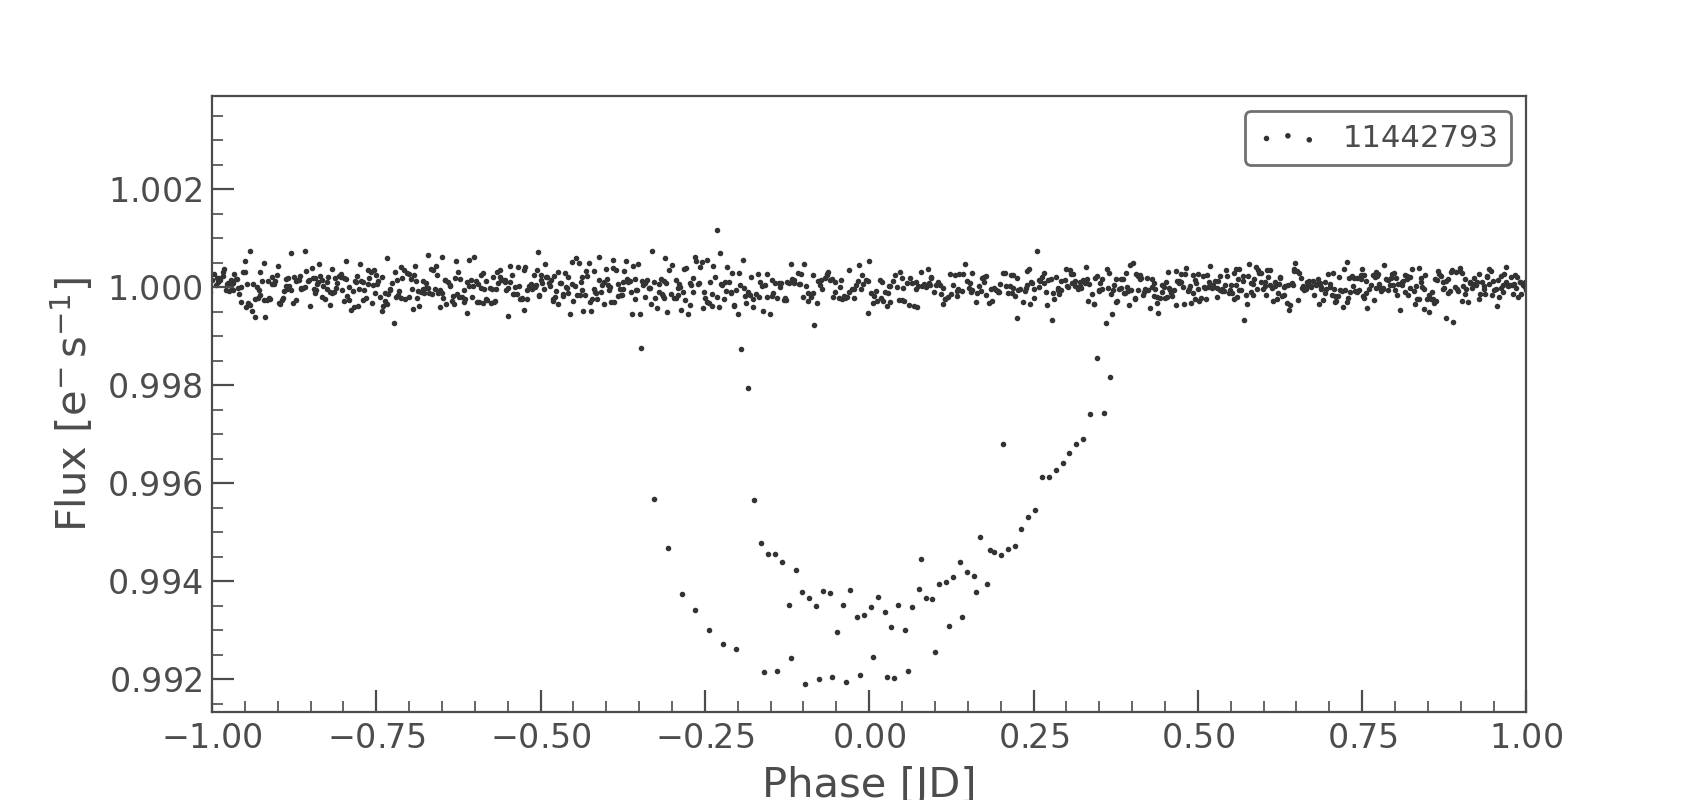

(-1.0, 1.0)

In [50]:
#folded light curve for 189d
clc.fold(period1,transit_time1).scatter();
plt.xlim(-1,1)

<IPython.core.display.Javascript object>


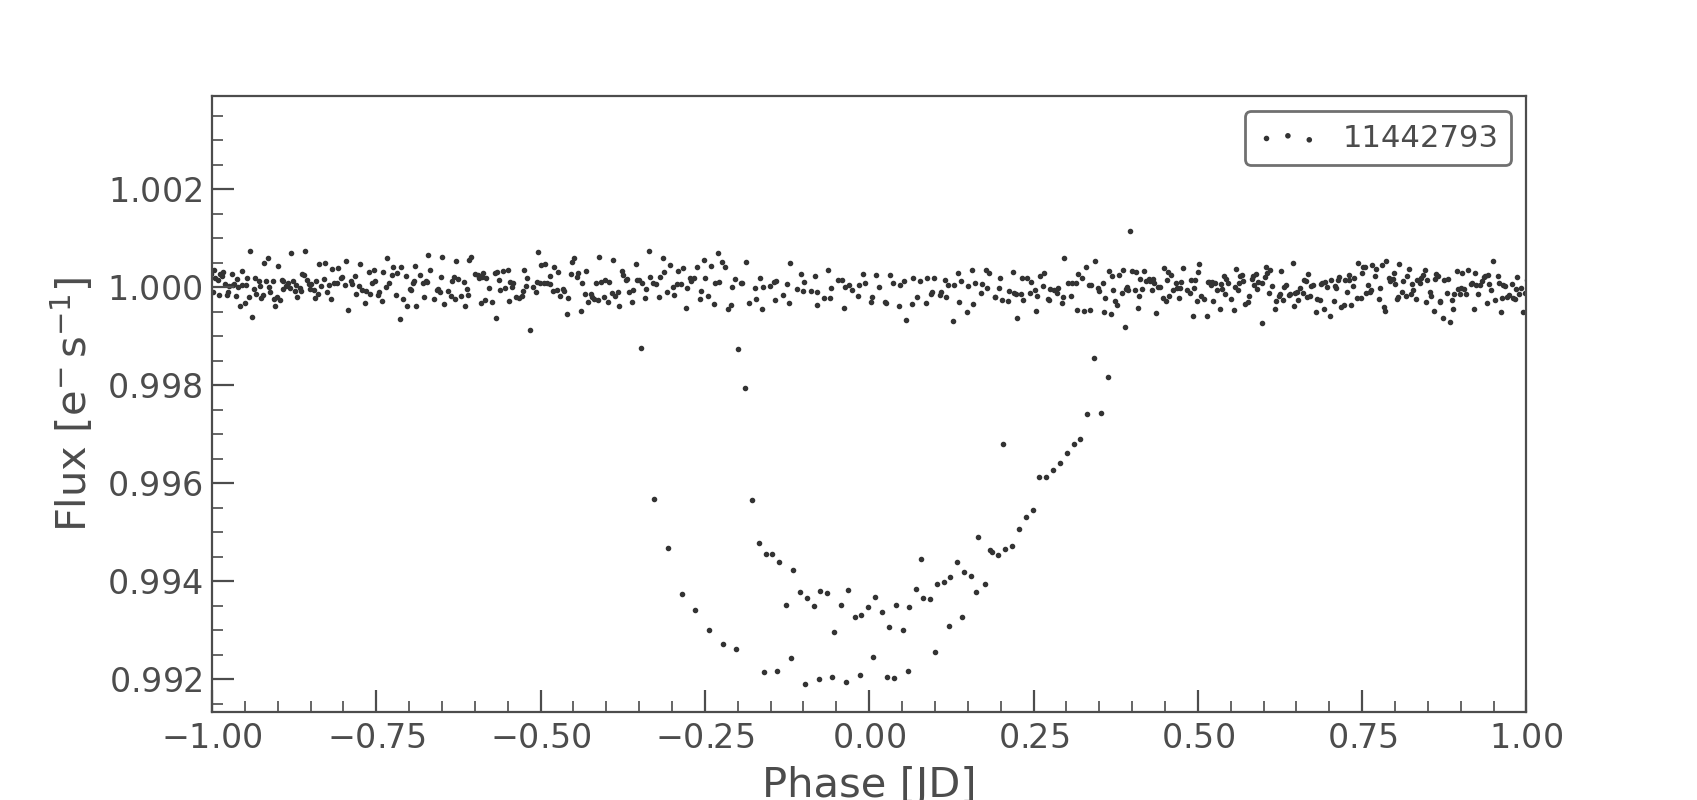

(-1.0, 1.0)

In [49]:
#folded light curve for 265d
clc.fold(period2,transit_time2).scatter();
plt.xlim(-1,1)

<IPython.core.display.Javascript object>


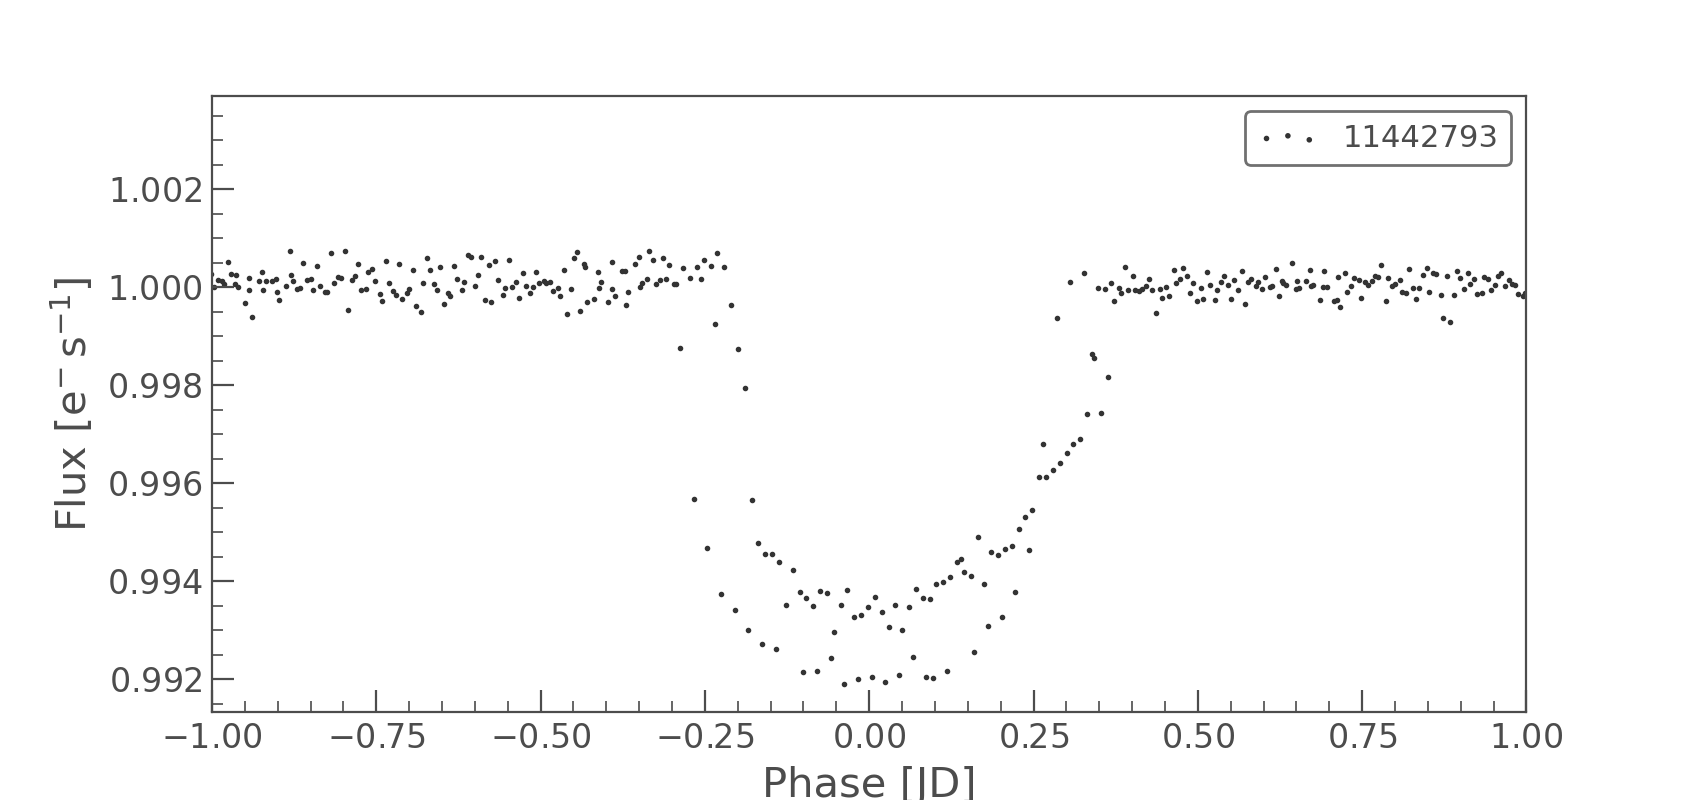

(-1.0, 1.0)

In [48]:
#folded light curve for 331d
clc.fold(period3,transit_time3).scatter();
plt.xlim(-1,1)